In [30]:
import torch
import numpy as np
import scipy as sp
import math
import copy
from matplotlib import pyplot as plt
from dataclasses import dataclass
from test_sampler import TestProblem

In [45]:
class Data:
    def __init__(self):
        self.test_problem = TestProblem()
        
        self.x = torch.tensor(torch.rand(1000), requires_grad=True)
        self.z_x = self.x.clone()
        self.q_x = self.x.clone()
        
        self.y = torch.tensor(torch.rand(2000), requires_grad=True)
        self.z_y = self.y.clone()
        self.q_y = self.y.clone()
        
        self.L_x = 5000
        self.L_y = 5000
        
        self.n_, self.alpha, self.tau = 0, 0, 0
        self.beta = 1 / 2
        self.k = 1000
        
        self.choose_block = lambda: np.random.choice([0, 1], p=[self.L_x ** self.beta / self.n_, self.L_y ** self.beta / self.n_])
        
        self.step(0)
    
    def calc_n_(self):
        return self.L_x ** self.beta + self.L_y ** self.beta
    
    def calc_alpha(self, i):
        return (i + 2) / (2 * self.n_ ** 2)
    
    def calc_tau(self, i):
        return 2 / (i + 2)
    
    def step(self, i):
        self.n_ = self.calc_n_()
        self.alpha = self.calc_alpha(i)
        self.tau = self.calc_tau(i)
        
    
    def calc_grad(self):
        self.test_problem.x = torch.tensor(self.x, requires_grad=True)
        self.test_problem.y = torch.tensor(self.y, requires_grad=True)
        result, grad_x, grad_y = self.test_problem.calc()
        return result, grad_x, grad_y
    
    def update_xy(self, i):
        x_upd = self.tau * self.z_x + (1 - self.tau) * self.q_x
        y_upd = self.tau * self.z_y + (1 - self.tau) * self.q_y
        self.x = x_upd
        self.y = y_upd
        
    def update_q_xy(self, i, index_p, grad_x, grad_y):  
        if index_p == 0:
            self.q_x = self.x - (1 / self.L_x) * grad_x
            self.q_y = self.q_y
        elif index_p == 1:
            self.q_x = self.q_x
            self.q_y = self.y - (1 / self.L_y) * grad_y
            
    def update_z_xy(self, i, index_p, grad_x, grad_y):
        if index_p == 0:
            self.z_x = self.z_x - (1 / self.L_x) * self.alpha * self.n_ * grad_x
            self.z_y = self.z_y
        elif index_p == 1:
            self.z_x = self.z_x
            self.z_y = self.z_y - (1 / self.L_y) * self.alpha * self.n_ * grad_y

In [49]:
def ACRCD():
    data = Data()
    history = []
    
    for i in range(data.k):
        data.step(i)
        data.update_xy(i)
        result, grad_x, grad_y = data.calc_grad()
        index_p = data.choose_block()
        
        data.update_q_xy(i, index_p, grad_x, grad_y)
        data.update_z_xy(i, index_p, grad_x, grad_y)
        
        history.append(result.item())
    
    return history

/var/folders/n9/tgs43kxj3nz79q8g8t2qzzzw0000gn/T/ipykernel_6527/3056260754.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.rand(1000), requires_grad=True)
/var/folders/n9/tgs43kxj3nz79q8g8t2qzzzw0000gn/T/ipykernel_6527/3056260754.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.rand(2000), requires_grad=True)
/var/folders/n9/tgs43kxj3nz79q8g8t2qzzzw0000gn/T/ipykernel_6527/3056260754.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.test_problem.x = torch.tensor(self.x,

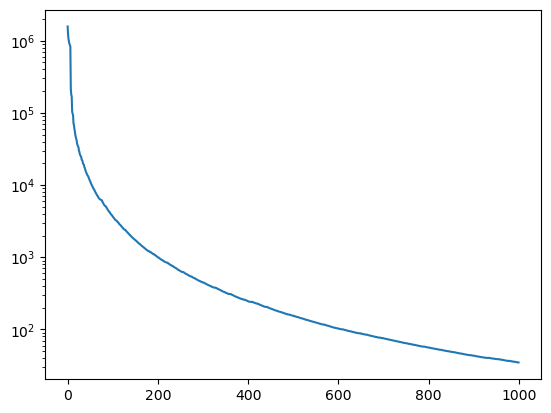

In [50]:
plt.plot(ACRCD())
plt.yscale('log')